# Convolutional Neural Networks

* Here, we use the MNIST dataset, a collection of 55,000 28x28 grey-scale images of handwritten digits with known labels. 
* A greyscale image can simply be thought of as a matrix, with each element representing the corresponding pixel's location on the greyscale (the higher the whiter, the lower the darker).


In [7]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import correlate
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam

import collections

Load in data.

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [8]:
collections.Counter(y_test)

Counter({0: 980,
         1: 1135,
         2: 1032,
         3: 1010,
         4: 982,
         5: 892,
         6: 958,
         7: 1028,
         8: 974,
         9: 1009})

In [3]:
X_train = X_train/255
X_test = X_test/255

In [4]:
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')


def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

plt.gray()
plt.close()

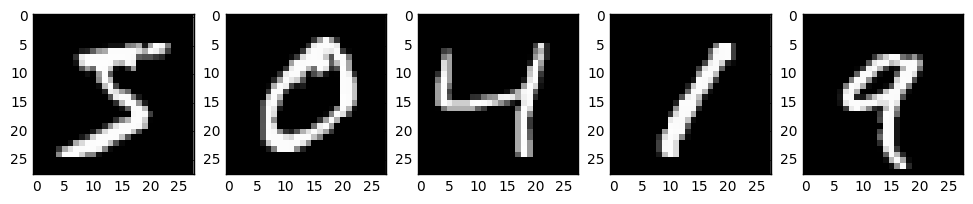

In [88]:
plots([X_train[i] for i in range(5)])

## Convolutional Layers
### Filters
Consider the following 3 x 3 matrix
$$F = \begin{bmatrix}-1&-1&-1\\1&1&1\\0&0&0\end{bmatrix},$$
which can visualize as

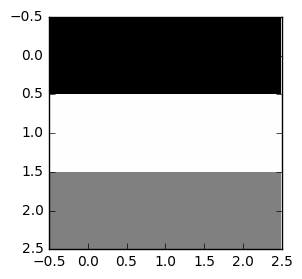

In [54]:
F = np.array([-1,1,0]*3).reshape(3,3).T
plot(F)

Now imagine taking the 3 x 3 matrix $F$ and positioning it over a 3 x 3 area of an image (e.g., bold part below), and let's multiply each overlapping value. Next, let's sum up these products. For example,
$$image = \begin{bmatrix}0&0&0.2&0.3&0&0.1\\0&\mathbf{0.2}&\mathbf{0.5}&\mathbf{0}&0&0\\0.1&\mathbf{0}&\mathbf{0}&\mathbf{0}&0&0.3\\0.1&\mathbf{0}&\mathbf{0.6}&\mathbf{0}&0&0.9\\0.5&0.6&0&0&0&0\end{bmatrix}~~~~~~~~~~ F = \begin{bmatrix}-1&-1&-1\\1&1&1\\0&0&0.\end{bmatrix}$$
The result is $0.2*(-1)+0.5*(-1)+0*(-1)+0*1+0*1+0*1+0*0+0.6*0+0*0 = -0.7$.
<br>
We will replace the center pixel (0) with this new value (-0.7). If we slide this 3x3 matrix over the entire image, we can construct a new image by replacing each pixel in the same manner just described.

In [55]:
A = np.array([[ 0.2,  0.5,  0. ],
              [ 0. ,  0. ,  0. ],
              [ 0. ,  0.6,  0. ]])
correlate(A, F, mode='constant', cval=0)

array([[ 0.7,  0.7,  0.5],
       [-0.7, -0.7, -0.5],
       [ 0.6,  0.6,  0.6]])

Another example (without zero padding):

![](http://ufldl.stanford.edu/tutorial/images/Convolution_schematic.gif)

#### MNIST images after convolution

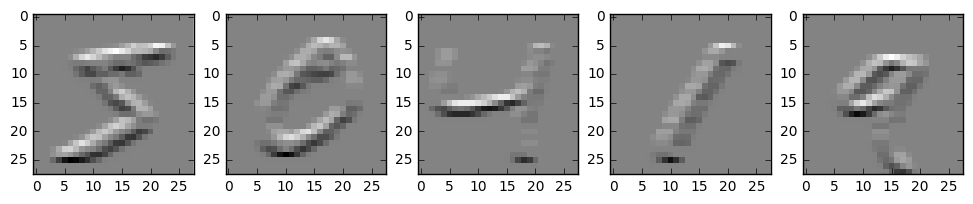

In [111]:
convs = [correlate(X_train[i], F, mode='constant', cval=0) for i in range(5)]
plots(convs)

The matrix $F$ we apply to the image is called a **filter**.  We can see that when we apply this matrix operation over the entire image, it **highlights the top edges**.

There are many kinds of filters to detect different things. If we rotate our top edge filter $F$, we can naturally detect different kinds of edges in different directions. 

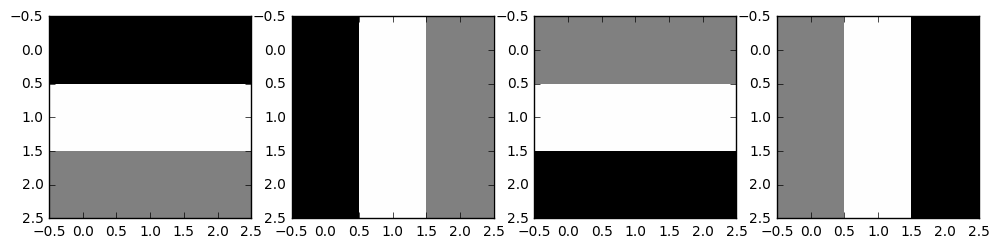

In [102]:
straights=[np.rot90(F,i) for i in range(4)]
plots(straights)

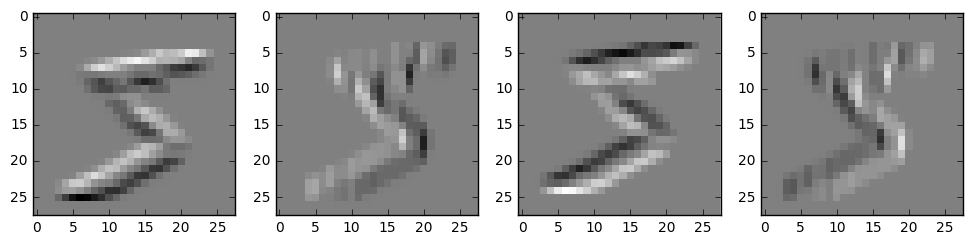

In [110]:
plots([correlate(X_train[0], rot, mode='constant', cval=0) for rot in straights])

**About the filter size.** Suppose that the size of filters is $d$ x $d$. Typically, people use an odd number for $d$. The winner of ImageNet in 2012 used $d=11$, but recently $d=3$ is more popular, such as in [VGGNet](http://www.robots.ox.ac.uk/~vgg/research/very_deep/).

### Zero-Padding

One thing we did not mention is how these filters operate on the *edge and corner pixels*. In "correlate()", the parameters "mode='constant', cval=0" is **adding extra borders of zero pixels** around the image so that the output shape from the filter is the same as the input shape.

### Filters in CNNs

* In a Convolutional Layer, our **weights belong to filters** that act on the input by performing convolution operation we described above. When this filter is applied to the entire image, it has essentially created a new representation of the original image.

* **Parameter sharing scheme** is used in Convolutional Layers to control the number of parameters.

* [**A nice convolution demo (two 3D filters)**](http://cs231n.github.io/assets/conv-demo/index.html). For multi-channel input data (e.g., RGB images have 3 channels), we may use 3D filters (of size d x d x 3).

* Given labelled images, we do not need to manually decide what filters work best at classification, we can simply train a model **using the filters (to be determined) as weights**!

## Activation

* **Sigmoid**. The sigmoid function has the form $\sigma(x)=1/(1+e^{-x})$.

 (-) A very undesirable property of the sigmoid neuron is that when the neuron’s activation **saturates** at either tail of 0 or 1, the gradient at these regions is almost zero.


* **<font color='red'>ReLU</font>**. The Rectified Linear Unit has become very popular. It computes the function $\sigma(x)=\max(0,x)$.

 (+) It was found to greatly accelerate the convergence of stochastic gradient descent compared to the sigmoid.
 
 (+) not expensive in computation.
 
 (-) can irreversibly die during training due to the zero part. A properly small learning rate may alleviate this problem.
 
 
* **Leaky ReLU**. Leaky ReLUs are one attempt to fix the “dying ReLU” problem. $\sigma(x)=1_{x<0}(\alpha x)+1_{x\ge 0}(x)$, where $\alpha$ is a small constant.

## Max-Pooling Layer

* A max-pooling layer reduces the dimensionality of images (resolution) by reducing the number of pixels in the image. 

* The most common form is to apply filters of size $2$x$2$ applied with a stride of 2 (discarding 75% of the activations):
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="50%"> 

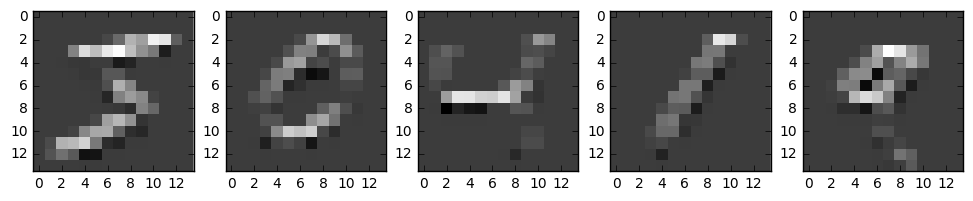

In [113]:
def pool(im): 
    return block_reduce(im, (2,2), np.max)

plots([pool(im) for im in convs])

* We do max pooling to "force" our NN to look at **larger areas** of the image at a time.
* Average pooling and $L_2$-norm pooling were often used historically but has recently fallen out of favor compared to the max pooling operation.

## Fully-connected Layers and Softmax

* It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. 

* We require that these fully connected outputs be interpreted as a probability. Therefore, we transform each output as a portion of a total sum. 

* **Softmax** is typically used in our final activation layer for classification problems: $$\frac{exp(x_i)}{\sum_i exp(x_i)},$$
which is equivalent to using a **logistic loss**.

## ConvNet Architectures

The most common form of a ConvNet architecture stacks a few **CONV-RELU layers**, follows them with **POOL layers**, and repeats this pattern until the image has been merged spatially to a small size, such as

**```INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC```**,

where the ```*``` indicates repetition, and the ```POOL?``` indicates an optional pooling layer. Moreover, ```N >= 0``` (usually ```N <= 3```), ```M >= 0```, ```K >= 0``` (usually ```K < 3```).

Example:

**VGGNet.** The runner-up in ILSVRC 2014 was the network from Karen Simonyan and Andrew Zisserman that became known as the VGGNet. Its main contribution was in showing that the depth of the network is a critical component for good performance. Their final best network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end.

VGG16 Structure:
```
INPUT: [224x224x3]        memory:  224*224*3=150K   weights: 0
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*3)*64 = 1,728
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*64)*64 = 36,864
POOL2: [112x112x64]  memory:  112*112*64=800K   weights: 0
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*64)*128 = 73,728
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*128)*128 = 147,456
POOL2: [56x56x128]  memory:  56*56*128=400K   weights: 0
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*128)*256 = 294,912
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
POOL2: [28x28x256]  memory:  28*28*256=200K   weights: 0
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*256)*512 = 1,179,648
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
POOL2: [14x14x512]  memory:  14*14*512=100K   weights: 0
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
POOL2: [7x7x512]  memory:  7*7*512=25K  weights: 0
FC: [1x1x4096]  memory:  4096  weights: 7*7*512*4096 = 102,760,448
FC: [1x1x4096]  memory:  4096  weights: 4096*4096 = 16,777,216
FC: [1x1x1000]  memory:  1000 weights: 4096*1000 = 4,096,000

TOTAL memory: 24M * 4 bytes ~= 93MB / image (only forward! ~*2 for bwd)
TOTAL params: 138M parameters
```

In [5]:
# data pre-processing
X_train = X_train.reshape(-1, 1,28, 28)
X_test = X_test.reshape(-1, 1,28, 28)
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

In [6]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=666)

In [10]:
model = Sequential()

model.add(Convolution2D(
    input_shape=(1, 28, 28),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     # Padding method
    data_format='channels_first',
))
model.add(Activation('relu'))

# Pooling layer 1 (max pooling) output shape (32, 14, 14)
model.add(MaxPooling2D(
    pool_size=2,
    strides=2,
    padding='same',    # Padding method
    data_format='channels_first',
))

# Conv layer 2 output shape (64, 14, 14)
model.add(Convolution2D(64, 5, strides=1, padding='same', data_format='channels_first'))
model.add(Activation('relu'))

# Pooling layer 2 (max pooling) output shape (64, 7, 7)
model.add(MaxPooling2D(2, 2, 'same', data_format='channels_first'))

# Fully connected layer 1 input shape (64 * 7 * 7) = (3136), output shape (1024)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

# Fully connected layer 2 to shape (10) for 10 classes
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(Adam(lr=1e-4), 'categorical_crossentropy', ['accuracy'])

How many epoch to run? Usually should be roughly tuned by the validation loss. 

In [9]:
print('Training ------------')
model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=3, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/3
 3712/54000 [=>............................] - ETA: 127s - loss: 0.7822 - acc: 0.8206

KeyboardInterrupt: 

In [143]:
model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 151s - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0652 - val_acc: 0.9840


In [159]:
model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 347s - loss: 0.0146 - acc: 0.9951 - val_loss: 0.0722 - val_acc: 0.9850


In [161]:
model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 298s - loss: 0.0101 - acc: 0.9966 - val_loss: 0.0936 - val_acc: 0.9820


In [162]:
print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)


Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.0687161623613

test accuracy:  0.9833


Check the architecture of this ConvNet!

In [149]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 28, 28)        832       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 14, 14)        51264     
_________________________________________________________________
activation_10 (Activation)   (None, 64, 14, 14)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 7, 7)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
__________

## Dropout and Batch Normalization (to prevent overfitting)

1.**Dropout** (which only happens during training) occurs after the activation layers, and **randomly sets activations to zero**. It turns out that this allows us to prevent overfitting. We can't overfit exactly to our training data when we're consistently throwing away information learned along the way. This allows our neural network to learn to generalize.

> *About the position of Dropout layer*: <br>
In the original paper of Dropout, the auther put Dropout layer before Activation (like the code below). But some people thought inserting it after Activation layer may be more reasonable. <br>
Another question is if we can apply dropout in convolutional layers. From the Srivastava/Hinton dropout paper:
"The additional gain in performance obtained by adding dropout in the convolutional layers (3.02% to 2.55%) is worth noting. One may have presumed that since the convolutional layers don’t have a lot of parameters, overfitting is not a problem and therefore dropout would not have much effect. However, dropout in the lower layers still helps because it provides noisy inputs for the higher fully connected layers which prevents them from overfitting."
They used 0.7 rate for conv dropout and 0.5 for fully connected.

> *Dropout rate*: setting dropout rate to 0.3 means we randomly throw away 30% elements. It really depends on the problem and experience.

2.Another good standard approach to reducing overfitting is **Batch Normalization**. 

In general, the inputs to your neural network should always be normalized. But during the training process, The weights may become unbalanced again which can typically cause instability.

(The following paragraph is from Jeremy Howard's [tutorial](http://wiki.fast.ai/index.php/Lesson_3_Notes).) <br>
One idea is to **normalize the activation outputs**. Unfortunately, this won't prevent SGD from trying to create an imbalanced weight again during the next back-propagation, and trying to solve the problem this way will just cause SGD to continuously try to under this activation layer normalization. Batch normalize extends this idea with two additions:

> after normalizing the activation layer, let's multiply the outputs by an arbitrarily set parameter, and add to that value an additional parameter, therefore setting a new standard deviation and mean

> Make all four of these values (the mean and standard deviation for normalization, and the two new parameters to set arbitrary mean and standard deviations after the normalization) **trainable**.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deviation in order to match the output scale, it can do so.
By default, you should always include batch normalization, and all modern neural networks do so because:

> Adding batchnorm to a model can result in 10x or more improvements in training speed

> Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to reduce overfitting.


Adding BatchNormalization and Dropout into the previous CNN.

In [155]:
model2 = Sequential([
         Convolution2D(input_shape=(1, 28, 28), filters=32, kernel_size=5, strides=1, padding='same', data_format='channels_first'),        
         BatchNormalization(),
         Activation('relu'),
         MaxPooling2D(2, 2, padding='same', data_format='channels_first'),
         Dropout(0.3),
         Convolution2D(64, 5, strides=1, padding='same', data_format='channels_first'),
         BatchNormalization(),
         Activation('relu'),
         MaxPooling2D(2, 2, padding='same', data_format='channels_first'),
         Dropout(0.3),
         Flatten(),
         Dense(1024),
         BatchNormalization(),
         Dropout(0.5),
         Activation('relu'),
         Dense(10),
         Activation('softmax')])
model2.compile(Adam(lr=1e-4), 'categorical_crossentropy', ['accuracy'])

In [157]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=3, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 263s - loss: 0.4325 - acc: 0.8657 - val_loss: 0.1528 - val_acc: 0.9547
Epoch 2/3
54000/54000 [==============================] - 403s - loss: 0.1502 - acc: 0.9529 - val_loss: 0.0965 - val_acc: 0.9710
Epoch 3/3
54000/54000 [==============================] - 454s - loss: 0.1079 - acc: 0.9662 - val_loss: 0.0713 - val_acc: 0.9785

Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.0518928443216

test accuracy:  0.9826


In [158]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=3, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 490s - loss: 0.0844 - acc: 0.9740 - val_loss: 0.0788 - val_acc: 0.9773
Epoch 2/3
54000/54000 [==============================] - 451s - loss: 0.0728 - acc: 0.9773 - val_loss: 0.0656 - val_acc: 0.9810
Epoch 3/3
54000/54000 [==============================] - 351s - loss: 0.0637 - acc: 0.9797 - val_loss: 0.0528 - val_acc: 0.9850

Testing ------------
10000/10000 [==============================] - 37s    

test loss:  0.0340958577736

test accuracy:  0.988


In [163]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 456s - loss: 0.0562 - acc: 0.9819 - val_loss: 0.0448 - val_acc: 0.9870

Testing ------------
10000/10000 [==============================] - 38s    

test loss:  0.0296008424795

test accuracy:  0.9897


In [164]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 415s - loss: 0.0491 - acc: 0.9844 - val_loss: 0.0412 - val_acc: 0.9870

Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.0268695290073

test accuracy:  0.991


In [165]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 266s - loss: 0.0454 - acc: 0.9862 - val_loss: 0.0449 - val_acc: 0.9865

Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.0284113447713

test accuracy:  0.9914


In [166]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 262s - loss: 0.0429 - acc: 0.9864 - val_loss: 0.0414 - val_acc: 0.9877

Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.02718659669

test accuracy:  0.9913


In [ ]:
print('Training ------------')
model2.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=1, batch_size=64)

print('\nTesting ------------')
# Evaluate the model with the metrics we defined earlier
loss, accuracy = model2.evaluate(X_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

Training ------------
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 261s - loss: 0.0384 - acc: 0.9877 - val_loss: 0.0365 - val_acc: 0.9887

Testing ------------
 9984/10000 [============================>.] - ETA: 0s
test loss:  0.0226871549224

test accuracy:  0.9925
